<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_07_Metaparameters_Part_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

## Numerical Analysis
import numpy as np
import scipy.stats as stats

## Dataset Management
import pandas as pd

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## High-Quality Figures
from IPython import display
display.set_matplotlib_formats("svg")

# Optimizers Comparison

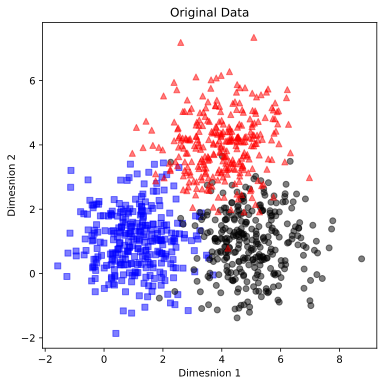

In [ ]:
# Compare three optimizers on the same dataset: SGD, RMSPop and Adam
# 300 data points per cluster
nPerClust = 300
blur = 1

A = [1,1]
B = [5,1]
C = [4,4]

# Generate the datapoints (2D data)
a = [A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]
c = [C[0] + np.random.randn(nPerClust)*blur, C[1] + np.random.randn(nPerClust)*blur]

# Concatenate the data into a single matrix
data_np = np.hstack((a,b,c)).T #(900x2 matrix)

# Define the labels
true_labels = np.hstack((np.zeros(nPerClust),
                         np.ones(nPerClust),
                         1+np.ones(nPerClust))) # 900x1 vector

# Convert them to tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(true_labels).long()

# Plot everything
fig = plt.figure(figsize=(6,6))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], "bs", alpha=0.5)
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], "ko", alpha=0.5)
plt.plot(data[np.where(labels==2)[0],0], data[np.where(labels==2)[0],1], "r^", alpha=0.5)
plt.title("Original Data")
plt.xlabel("Dimesnion 1")
plt.ylabel("Dimesnion 2")
plt.show()

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1)

# Convert to PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into data loader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [ ]:
print("There are {} batches, each with {} samples".format(len(train_loader), batchsize))

There are 50 batches, each with 16 samples


In [ ]:
# Create the class for optimizers
def createTheQwertyNet(optimAlgo):

    # Define the class
    class QwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input Layer
            self.input = nn.Linear(2,8)

            # Hidden Layer
            self.fc1 = nn.Linear(8,8)

            # Output Layer
            self.output = nn.Linear(8,3)
        # Forward Pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)

    # Create the model Instance
    net = QwertyNet()

    # Define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Define the optimizer
    optimfun = getattr(torch.optim,optimAlgo)
    optimizer = optimfun(net.parameters(),lr = 0.01)

    return net, lossfun, optimizer

In [ ]:
# Test to see whether the model works
optims = ["SGD", "RMSprop", "Adam"]

for i in optims:
    optim = createTheQwertyNet(i)[2]
    print(optim)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.01
    momentum: 0
    weight_decay: 0
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [ ]:
# Create the function that trains the model
def function2TrainTheModel(optimType):

    # Define the nuymber of epochs
    numepochs = 50 # 100 is too much as shown in the previous section
    # Create a new model
    net, lossfun, optimizer = createTheQwertyNet(optimType)

    # Initialize the losses
    losses = []
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Switch to training mode
        net.train()

        # Store the losses and accuracies of batches
        batchLoss = []
        batchAcc = []

        # Loop over the batches
        for X,y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Losses from this particular batch
            batchLoss.append(loss.item())

            # Accuracy of the particular batch
            matches = (torch.argmax(yHat,axis=1)==y).float()
            accuracyPct = 100*torch.mean(matches)
            batchAcc.append(accuracyPct)
        # End the loop of batch training

        # Store losses and accuracies for this epoch
        losses.append(np.mean(batchLoss))
        trainAcc.append(np.mean(batchAcc))

        # Shift to testing mode
        net.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
    # Finish the whole thing
    return trainAcc, testAcc, losses, net

In [ ]:
# Define a function to plot the results
def plotTheResults(optimType):

    # Compute the accuracy over the entire dataset
    yHat = net(data)
    predictions = torch.argmax(yHat,axis=1)
    accuracy = (predictions == labels).float()
    totalAcc = torch.mean(100*accuracy).item()

    # Compute Accuracy by Group
    accuracyByGroup = np.zeros(3)
    for i in range(3):
        accuracyByGroup[i] = 100*torch.mean(accuracy[labels==i])
    
    # Create the plots
    fig,ax = plt.subplots(2,2, figsize=(10,6))

    ax[0,0].plot(losses)
    ax[0,0].set_ylabel("Loss")
    ax[0,0].set_xlabel("Epoch")
    ax[0,0].set_title("{} Losses".format(optimType))

    ax[0,1].plot(trainAcc, label="Train Accuracy")
    ax[0,1].plot(testAcc, label="Test Accuracy")
    ax[0,1].set_ylabel("Accuracy (%)")
    ax[0,1].set_xlabel("Epoch")
    ax[0,1].set_title("{} Accuracy".format(optimType))
    ax[0,1].legend()

    # Overall Accuracy By Group
    ax[1,0].bar(range(3), accuracyByGroup)
    ax[1,0].set_ylim([np.min(accuracyByGroup)-5, np.max(accuracyByGroup)+5])
    ax[1,0].set_xticks([0,1,2])
    ax[1,0].set_ylabel("Accuracy (%)")
    ax[1,0].set_xlabel("Group")
    ax[1,0].set_title("{} Accuracy by Group".format(optimType))

    # Scatterplots for correctly and incorrectly labeles data
    colorshapes = ["bs", "ko", "g^"]
    for i in range(3):
        # Plot all the datapoints
        ax[1,1].plot(data[labels==i,0], data[labels==i,1], colorshapes[i],
                     alpha=0.3, label=f"Group {i}")
        
        # Cross-out incorrectly labeled data
        idxErr = (accuracy==0) & (labels==i)
        ax[1,1].plot(data[idxErr,0], data[idxErr,1], "rx")
    
    ax[1,1].set_title("{:.2f}: Total Accuracy".format(totalAcc))
    ax[1,1].set_xlabel("Data Dimesnion 1")
    ax[1,1].set_ylabel("Data Dimesnion 2")
    ax[1,1].legend()

    plt.tight_layout()
    plt.show()

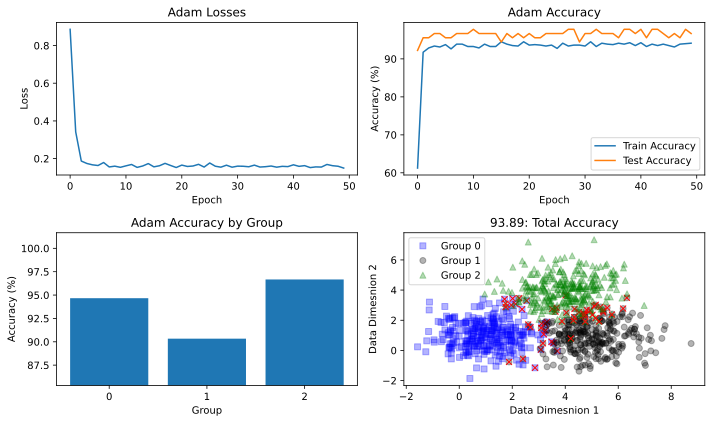

In [ ]:
# run for one optimizer to make sure it works
optimType = "Adam"

# initialize the mokdel
trainAcc, testAcc, losses, net = function2TrainTheModel(optimType)

# Visualize the Whole thing
plotTheResults(optimType)

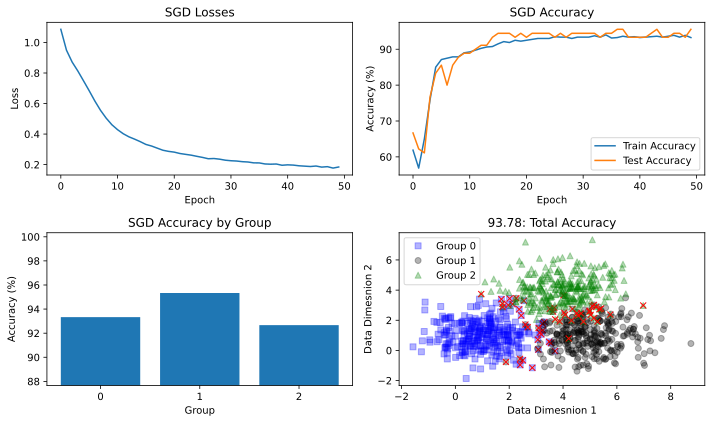

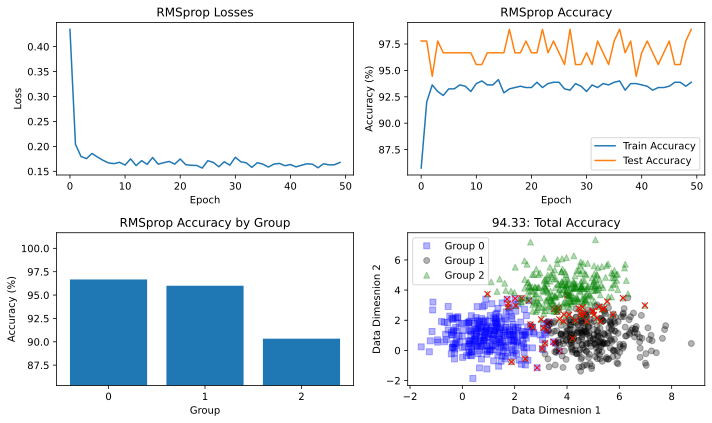

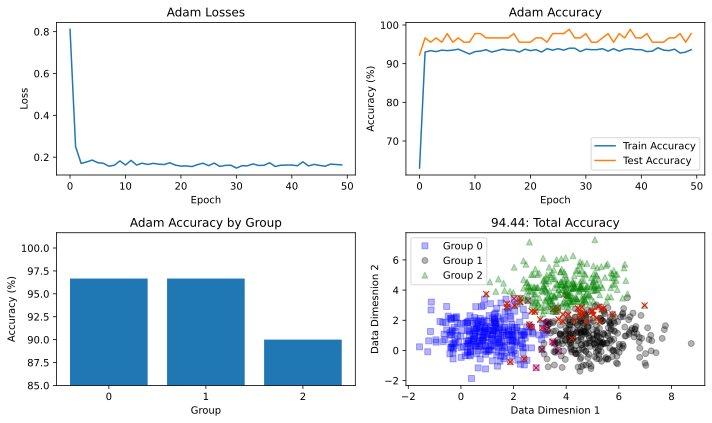

In [ ]:
# Run the model through all the optimizers
# Average Performance
performance = []

for opto in ["SGD", "RMSprop", "Adam"]:

    trainAcc, testAcc, losses, net = function2TrainTheModel(opto)
    plotTheResults(opto)

    # Store the fnal results
    train = np.mean(trainAcc[-10:])
    test = np.mean(testAcc[-10:])

    performance.append("{}: Train = {:.1f}%, Test = {:.1f}%".format(opto, train, test))

In [ ]:
performance
# Adam is very very fast, followed by RMSprop and finally SGD, while performance is similar

['SGD: Train = 93.5%, Test = 94.1%',
 'RMSprop: Train = 93.6%, Test = 96.9%',
 'Adam: Train = 93.4%, Test = 96.6%']

# Optimizers and Learning Rate

In [ ]:
# Test the same dataset for different optimizers and learning rates at once
# Create the class for optimizers
def createTheQwertyNet(optimAlgo, learningrate):

    # Define the class
    class QwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input Layer
            self.input = nn.Linear(2,8)

            # Hidden Layer
            self.fc1 = nn.Linear(8,8)

            # Output Layer
            self.output = nn.Linear(8,3)
        # Forward Pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)

    # Create the model Instance
    net = QwertyNet()

    # Define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Define the optimizer
    optimfun = getattr(torch.optim,optimAlgo)
    optimizer = optimfun(net.parameters(),lr = learningrate)

    return net, lossfun, optimizer

In [ ]:
# Create the function that trains the model
def function2TrainTheModel(optimType, learningrate):

    # Define the nuymber of epochs
    numepochs = 50 # 100 is too much as shown in the previous section
    # Create a new model
    net, lossfun, optimizer = createTheQwertyNet(optimType, learningrate)

    # Initialize the losses
    losses = []
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Switch to training mode
        net.train()

        # Store the losses and accuracies of batches
        batchLoss = []
        batchAcc = []

        # Loop over the batches
        for X,y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Losses from this particular batch
            batchLoss.append(loss.item())

            # Accuracy of the particular batch
            matches = (torch.argmax(yHat,axis=1)==y).float()
            accuracyPct = 100*torch.mean(matches)
            batchAcc.append(accuracyPct)
        # End the loop of batch training

        # Store losses and accuracies for this epoch
        losses.append(np.mean(batchLoss))
        trainAcc.append(np.mean(batchAcc))

        # Shift to testing mode
        net.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
    # Finish the whole thing
    return trainAcc, testAcc, losses, net

In [ ]:
# Experiment
learningRates = np.logspace(np.log10(0.0001), np.log10(0.1), 20)
optimTypes = ["SGD", "RMSprop", "Adam"]

# Initialize the performance Matrix
finalPerformance = np.zeros((len(learningRates), len(optimTypes)))

# Iterate to run all experiments
for idx_o, opto in enumerate(optimTypes):
    for idx_l, lr in enumerate(learningRates):
        trainAcc, testAcc, losses, net = function2TrainTheModel(opto, lr)
        finalPerformance[idx_l, idx_o] = np.mean(testAcc[-10:])

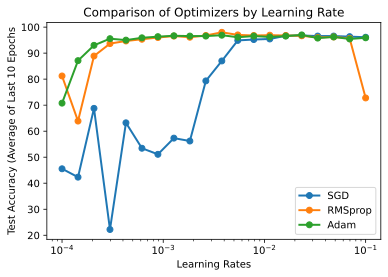

In [ ]:
# Plot the results
plt.plot(learningRates, finalPerformance, "o-", linewidth=2)
plt.legend(optimTypes)
plt.xscale("log")
plt.xlabel("Learning Rates")
plt.ylabel("Test Accuracy (Average of Last 10 Epochs")
plt.title("Comparison of Optimizers by Learning Rate")
plt.show()

# Adam with L2 Regularization

In [ ]:
# Use previous code from regular_L2regu and metaparams_CodeChallengeOptimizers
# Modify the code to use Adam optimizer with lr=0.001, minibatch=32 and L2 regularization (6 different lambda values)

# Change BatchSize
# Translate into data loader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [ ]:
# Define the class
def createTheQwertyNet(L2lambda):

    # Define the class
    class QwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input Layer
            self.input = nn.Linear(2,8)

            # Hidden Layer
            self.fc1 = nn.Linear(8,8)

            # Output Layer
            self.output = nn.Linear(8,3)
        # Forward Pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)

    # Create the model Instance
    net = QwertyNet()

    # Define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=0.001,weight_decay=L2lambda)

    return net, lossfun, optimizer

In [ ]:
# Create the function that trains the model
def function2TrainTheModel(L2lambda):

    # Define the number of epochs
    numepochs = 50
    # Create a new model
    net, lossfun, optimizer = createTheQwertyNet(L2lambda)

    # Initialize the losses
    losses = []
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Switch to training mode
        net.train()

        # Store the losses and accuracies of batches
        batchLoss = []
        batchAcc = []

        # Loop over the batches
        for X,y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Losses from this particular batch
            batchLoss.append(loss.item())

            # Accuracy of the particular batch
            matches = (torch.argmax(yHat,axis=1)==y).float()
            accuracyPct = 100*torch.mean(matches)
            batchAcc.append(accuracyPct)
        # End the loop of batch training

        # Store losses and accuracies for this epoch
        losses.append(np.mean(batchLoss))
        trainAcc.append(np.mean(batchAcc))

        # Shift to testing mode
        net.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
    # Finish the whole thing
    return trainAcc, testAcc, losses, net

In [ ]:
# Define the range of lambdas
l2lambdas = np.linspace(0,0.1,6)
numepochs = 50
# Initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(l2lambdas)))
accuracyResutlsTest = np.zeros((numepochs,len(l2lambdas)))
losses_lambda = np.zeros((numepochs, len(l2lambdas)))

# Loop over the lambdas
for l in range(len(l2lambdas)):
    trainAcc, testAcc, losses, net = function2TrainTheModel(l2lambdas[l])

    # Store the results
    accuracyResultsTrain[:,l] = trainAcc
    accuracyResutlsTest[:,l] = testAcc
    losses_lambda[:,l] = losses

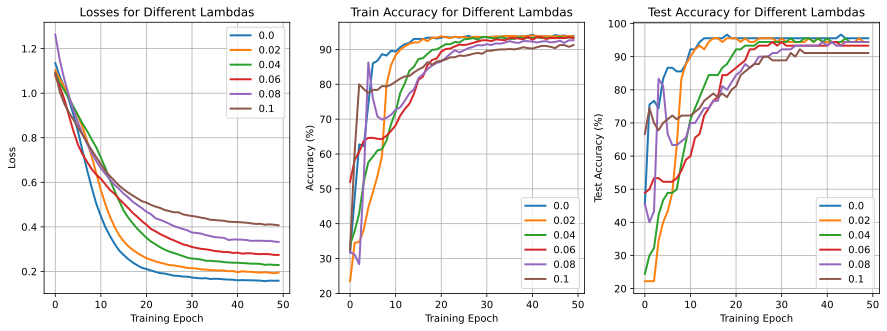

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

ax[0].plot(losses_lambda, linewidth=2)
ax[0].set_title("Losses for Different Lambdas")
ax[0].set_xlabel("Training Epoch")
ax[0].set_ylabel("Loss")

ax[1].plot(accuracyResultsTrain, linewidth=2)
ax[1].set_title("Train Accuracy for Different Lambdas")
ax[1].set_xlabel("Training Epoch")
ax[1].set_ylabel("Accuracy (%)")

ax[2].plot(accuracyResutlsTest, linewidth=2)
ax[2].set_title("Test Accuracy for Different Lambdas")
ax[2].set_xlabel("Training Epoch")
ax[2].set_ylabel("Test Accuracy (%)")

# Easier to read legend
leglabels = [np.round(i,3) for i in l2lambdas]

# Common features
for i in range(3):
    ax[i].legend(leglabels)
    ax[i].grid()

plt.show()
# L2 doesnt help, and this is because the dataset is very small and there is not much to regularize here!

# Learning Rate Decay

In [ ]:
# Change batchsize back to 16
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [ ]:
# Use the same dataset above
# Define the class
def createTheQwertyNet(initialLR):

    # Define the class
    class QwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input Layer
            self.input = nn.Linear(2,8)

            # Hidden Layer
            self.fc1 = nn.Linear(8,8)

            # Output Layer
            self.output = nn.Linear(8,3)
        # Forward Pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)

    # Create the model Instance
    net = QwertyNet()

    # Define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = torch.optim.SGD(net.parameters(),lr=initialLR)
    # Total number of data points we have in training
    stepsize = batchsize*len(train_loader)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=stepsize, gamma=0.5)

    return net, lossfun, optimizer, scheduler

In [ ]:
# The number of steps until learning rate changes
len(train_loader)*batchsize

800

In [ ]:
# Explore the learning rate decay parameter
net = createTheQwertyNet(0.01)[0]

# A new optimizer
optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
# gamma is a multiplicative factor we change the learning rate by
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5, gamma=1/2)

# Test the change in learning rate
for epoch in range(3):
    for batchnum in range(10):
        print("Batch {}, epoch {}, LR = {}".format(batchnum, epoch, scheduler.get_last_lr()[0]))
        # Will keep track of the changes
        scheduler.step()

Batch 0, epoch 0, LR = 0.01
Batch 1, epoch 0, LR = 0.01
Batch 2, epoch 0, LR = 0.01
Batch 3, epoch 0, LR = 0.01
Batch 4, epoch 0, LR = 0.01
Batch 5, epoch 0, LR = 0.005
Batch 6, epoch 0, LR = 0.005
Batch 7, epoch 0, LR = 0.005
Batch 8, epoch 0, LR = 0.005
Batch 9, epoch 0, LR = 0.005
Batch 0, epoch 1, LR = 0.0025
Batch 1, epoch 1, LR = 0.0025
Batch 2, epoch 1, LR = 0.0025
Batch 3, epoch 1, LR = 0.0025
Batch 4, epoch 1, LR = 0.0025
Batch 5, epoch 1, LR = 0.00125
Batch 6, epoch 1, LR = 0.00125
Batch 7, epoch 1, LR = 0.00125
Batch 8, epoch 1, LR = 0.00125
Batch 9, epoch 1, LR = 0.00125
Batch 0, epoch 2, LR = 0.000625
Batch 1, epoch 2, LR = 0.000625
Batch 2, epoch 2, LR = 0.000625
Batch 3, epoch 2, LR = 0.000625
Batch 4, epoch 2, LR = 0.000625
Batch 5, epoch 2, LR = 0.0003125
Batch 6, epoch 2, LR = 0.0003125
Batch 7, epoch 2, LR = 0.0003125
Batch 8, epoch 2, LR = 0.0003125
Batch 9, epoch 2, LR = 0.0003125


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [ ]:
# Create the function that trains the model
def function2TrainTheModel(initialLR, toogleDynamicLR):

    # Define the number of epochs
    numepochs = 50
    # Create a new model
    net, lossfun, optimizer, scheduler = createTheQwertyNet(initialLR)

    # Initialize the losses
    losses = []
    trainAcc = []
    testAcc = []
    currentLR = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Switch to training mode
        net.train()

        # Store the losses and accuracies of batches
        batchLoss = []
        batchAcc = []

        # Loop over the batches
        for X,y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Step the learning rate scheduler: Switch it on/off using boolean
            # It has to be included after the optimizer step
            if toogleDynamicLR:
                scheduler.step()

            # Losses from this particular batch
            batchLoss.append(loss.item())

            # Accuracy of the particular batch
            matches = (torch.argmax(yHat,axis=1)==y).float()
            accuracyPct = 100*torch.mean(matches)
            batchAcc.append(accuracyPct)

            # Visualize the changes in learning rate over training
            currentLR.append(scheduler.get_last_lr()[0])
        # End the loop of batch training

        # Store losses and accuracies for this epoch
        losses.append(np.mean(batchLoss))
        trainAcc.append(np.mean(batchAcc))

        # Shift to testing mode
        net.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
    # Finish the whole thing
    return trainAcc, testAcc, losses, net, currentLR

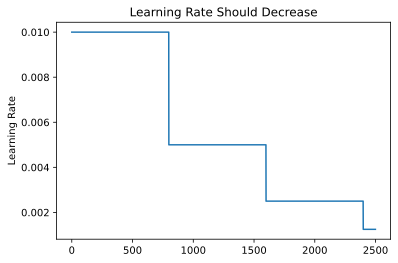

In [ ]:
# Test whether the learning rate is really working
trainAcc, testAcc, losses, net, currentLR = function2TrainTheModel(0.01,True)

plt.plot(currentLR)
plt.title("Learning Rate Should Decrease")
plt.ylabel("Learning Rate")
plt.show()

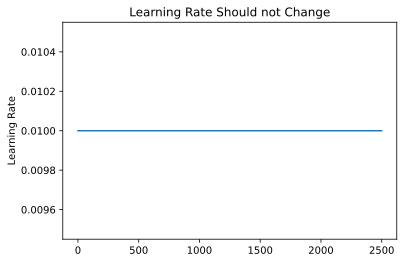

In [ ]:
trainAcc, testAcc, losses, net, currentLR = function2TrainTheModel(0.01,False)
plt.plot(currentLR)
plt.title("Learning Rate Should not Change")
plt.ylabel("Learning Rate")
plt.show()

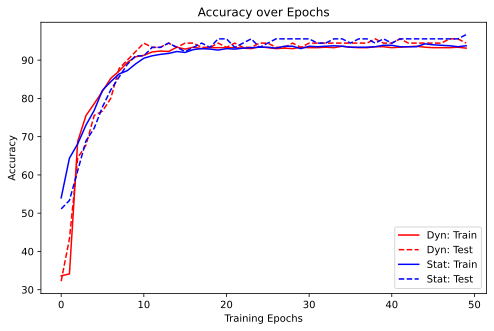

In [ ]:
# Run the Experiment
trainDyn, testDyn, losses, net, currentLR = function2TrainTheModel(0.01, True)
trainSt, testSt, losses, net, currentLR = function2TrainTheModel(0.01, False)

fig = plt.figure(figsize=(8,5))
plt.plot(trainDyn, "r", label="Dyn: Train")
plt.plot(testDyn, "r--", label="Dyn: Test")

plt.plot(trainSt, "b", label="Stat: Train")
plt.plot(testSt, "b--", label="Stat: Test")

plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()
# Not much difference because its a simple model with simple data structure